# Plot uni-mutational fractions

Draws histograms of $\dfrac{N_2}{N_2 + N_3 + N_4}$ over all nth-CP positions in each sequence.

### TODO

- Filter just to positions with a mutation rate > 0.5% (support doing either, since one is for main text and one is for appendix). Probably best to just make this a function that takes the min freq as a parameter, with None being an option.
- ~~Tile into a single grid where each row is a diff genome, and cols are CP 1 / 2 / 3. Save to a file.~~
- ~~Add in NCP as an option -- see gene histograms for example. Not as important.~~

In [1]:
%run "ComputeUniMutationalFractions.ipynb"

CAMP, CP 1: mean (valid) f-value = 0.9116174285691164, num valid f-values = 213,381
CAMP, CP 2: mean (valid) f-value = 0.906167033532244, num valid f-values = 222,105
CAMP, CP 3: mean (valid) f-value = 0.9057429522198897, num valid f-values = 223,807
CAMP, CP 4: mean (valid) f-value = 0.8950599056321636, num valid f-values = 63,216
BUT, CP 1: mean (valid) f-value = 0.935449762380203, num valid f-values = 171,084
BUT, CP 2: mean (valid) f-value = 0.9330492521629817, num valid f-values = 177,240
BUT, CP 3: mean (valid) f-value = 0.9307000198511338, num valid f-values = 180,300
BUT, CP 4: mean (valid) f-value = 0.9290660857555323, num valid f-values = 53,813
BACT, CP 1: mean (valid) f-value = 0.9291346009343846, num valid f-values = 336,819
BACT, CP 2: mean (valid) f-value = 0.9288745354212982, num valid f-values = 345,003
BACT, CP 3: mean (valid) f-value = 0.9307733962079723, num valid f-values = 335,877
BACT, CP 4: mean (valid) f-value = 0.9254512387333395, num valid f-values = 245,797


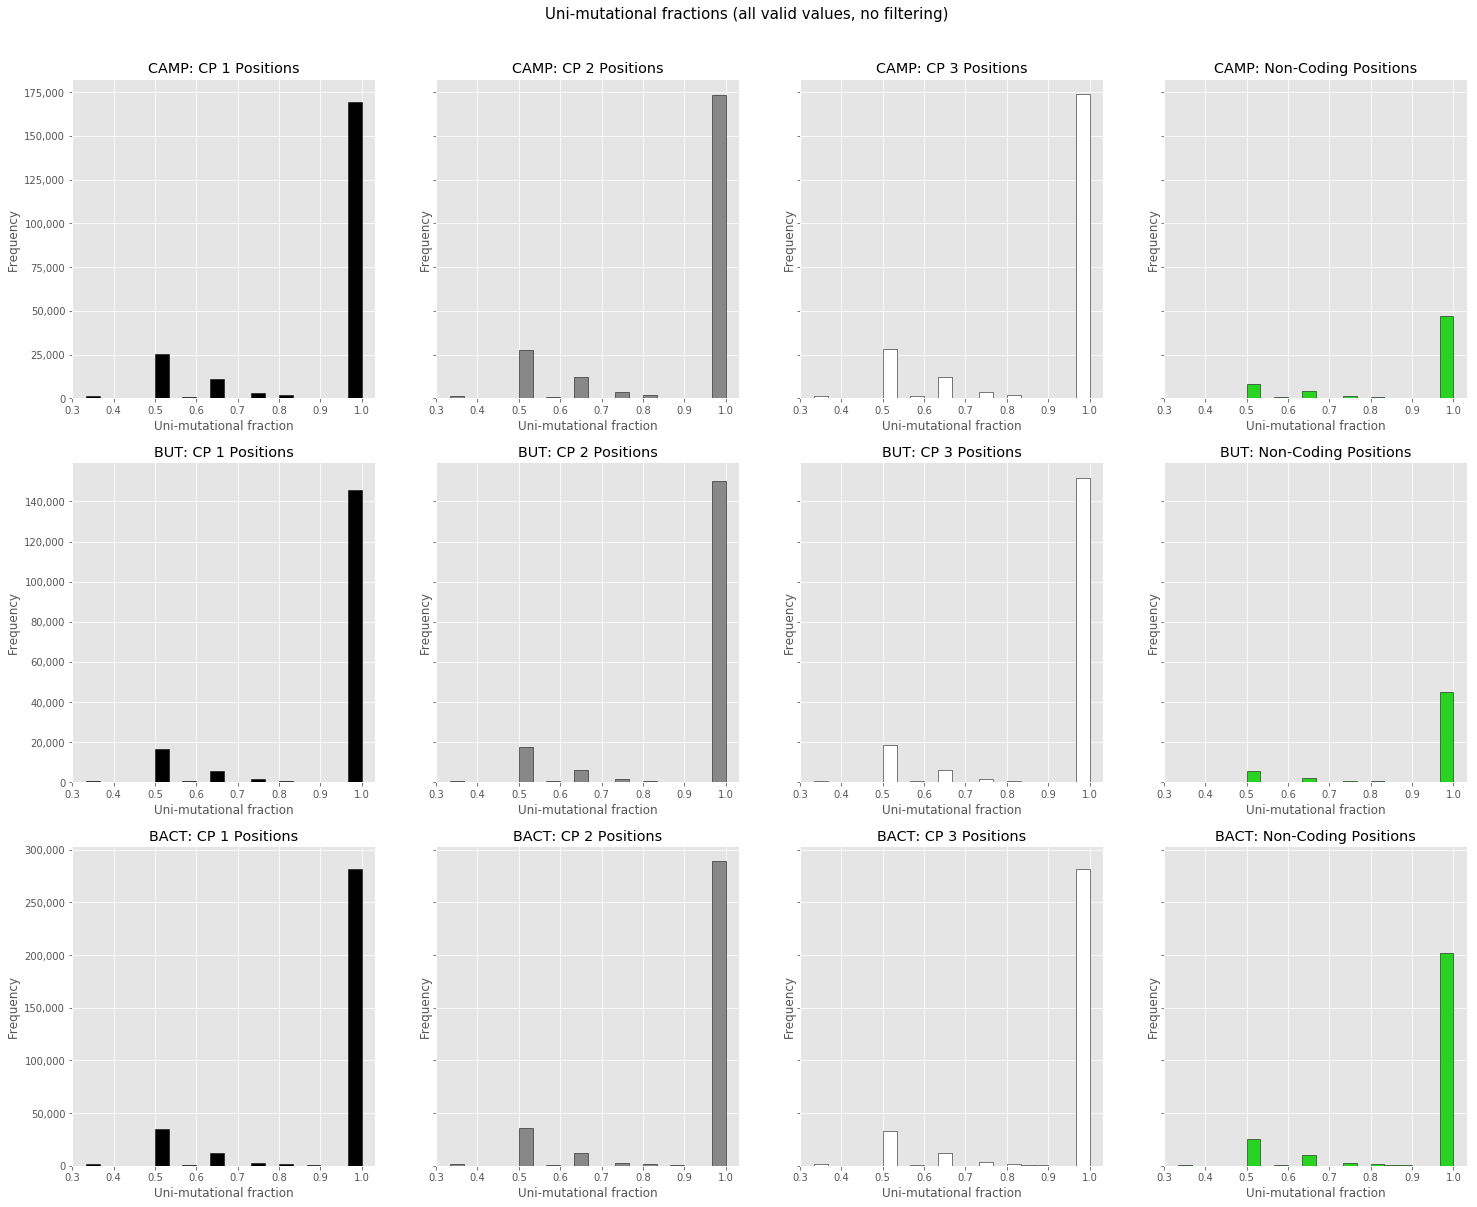

In [5]:
from parse_sco import parse_sco

fig, axes = pyplot.subplots(3, 4, sharey="row")

for figrow, seq in enumerate(SEQS):
    df = parse_sco(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
    )
    # Go through each gene in this sequence. Find the CPs (and non-coding positions).
    # Record each position's "f" value, if present. Plot
    # a histogram of these f-values. (CP 4 is shorthand for "non-coding".)
    num2fvals = {1: [], 2: [], 3: [], 4: []}
    bases_in_genes = set()
    for gene in df.itertuples():
        i = 1
        pos_interval = get_pos_interval_from_gene(gene)
        bases_in_genes |= set(pos_interval)
        for pos in pos_interval:
            f = seq2pos2f[seq][str(pos)]
            # Can use this if statement to filter out certain f-values, e.g. < 1
            if f is not None:
                num2fvals[i].append(f)
            if i == 1:
                i = 2
            elif i == 2:
                i = 3
            elif i == 3:
                i = 1
            else:
                raise ValueError("Codon position modulo calculation is broken :|")

        if i != 1:
            raise ValueError("Gene length not divisible by 3.")
    
    bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
    for pos in bases_not_in_genes:
        f = seq2pos2f[seq][str(pos)]
        if f is not None:
            num2fvals[4].append(f)
    
    for figcol, cp in enumerate([1, 2, 3, 4]):
        print("{}, CP {}: mean (valid) f-value = {}, num valid f-values = {:,}".format(
            seq2name[seq], cp, mean(num2fvals[cp]), len(num2fvals[cp])
        ))
        ax = axes[figrow, figcol]
        ax.hist(num2fvals[cp], bins=20, color=cp2color[cp], edgecolor=BORDERCOLOR)
        if cp != 4:
            ax.set_title("{}: CP {} Positions".format(seq2name[seq], cp))
        else:
            ax.set_title("{}: Non-Coding Positions".format(seq2name[seq]))
        ax.set_xlabel(r"Uni-mutational fraction")
        ax.set_ylabel("Frequency")
        use_thousands_sep(ax.get_yaxis())
        # This is a hack to make all CP plots in a row have the same y-axis. Ideally this'd be automatic
        # but uhhhh elbow grease is easier lol
#         if seq2name[seq] == "CAMP":
#             pyplot.ylim(0, 28000)
#         elif seq2name[seq] == "BUT":
#             pyplot.ylim(0, 18000)
#         else:
#             pyplot.ylim(0, 35000)
#         pyplot.show()

fig.suptitle(
    "Uni-mutational fractions (all valid values, no filtering)",
    fontsize="15",
    y=0.93
)
fig.set_size_inches(25, 20)
fig.savefig("figs/unimut-fractions-all.png", bbox_inches="tight")